In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from astropy.coordinates import get_sun, get_body, FK4
from astropy.time import Time
from astropy import units as u

In [2]:
def bandToFreq(band):
    # Convert the input to a numpy array (if it's not already)
    band = np.asarray(band)
    
    # Create a mapping of band numbers to frequency values
    band_to_freq = {
        1: 0.45, 2: 0.70, 3: 0.90, 4: 1.31,
        5: 2.20, 6: 3.93, 7: 4.70, 8: 6.55, 9: 9.18
    }

    # Use np.vectorize to apply the mapping to each element in the array
    freq = np.vectorize(lambda b: band_to_freq.get(b, -1))(band)
    
    return freq

In [3]:
def calculate_moon_source_separation(df, source_ra_deg, source_dec_deg, moon_radius=1737.4):
    """
    Calculates the angular separation between the center of the Moon and a celestial source
    as viewed from an orbiter in a Lunicentric B1950 coordinate frame, and determines
    if the source is blocked (occulted) by the Moon.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the orbiter's position. 
        Must contain columns: ['position_x', 'position_y', 'position_z']
        Units must match the units of `moon_radius` (default km).
        
    source_ra_deg : float
        Right Ascension of the source in B1950 degrees.

    source_dec_deg : float
        Declination of the source in B1950 degrees.
        
    moon_radius : float, optional
        Radius of the Moon. Default is 1737.4 (km). 
        Ensure this matches the units of the position columns in `df`.

    Returns:
    --------
    pd.DataFrame
        A DataFrame with two columns:
        - 'separation_angle_deg': The angle between Moon center and Source (degrees).
        - 'is_blocked': Boolean flag (True if source is behind the Moon).
    """
    
    # 1. Convert Source RA/Dec to a Cartesian Unit Vector (B1950)
    alpha = np.radians(source_ra_deg)
    delta = np.radians(source_dec_deg)
    
    source_uvec = np.array([
        np.cos(delta) * np.cos(alpha),
        np.cos(delta) * np.sin(alpha),
        np.sin(delta)
    ])
    
    # 2. Define Vector from Orbiter to Moon Center
    # In Lunicentric, Moon is at (0,0,0). Vector is -1 * Orbiter Position
    v_orb_to_moon_x = -df['position_x']
    v_orb_to_moon_y = -df['position_y']
    v_orb_to_moon_z = -df['position_z']
    
    # 3. Calculate Distance from Orbiter to Moon Center
    dist_orb_to_moon = np.sqrt(
        v_orb_to_moon_x**2 + 
        v_orb_to_moon_y**2 + 
        v_orb_to_moon_z**2
    )
    
    # 4. Calculate Separation Angle
    # Dot Product
    dot_product = (
        v_orb_to_moon_x * source_uvec[0] +
        v_orb_to_moon_y * source_uvec[1] +
        v_orb_to_moon_z * source_uvec[2]
    )
    
    # Normalize dot product by magnitude of vector A (dist) and vector B (1.0)
    cos_theta = np.clip(dot_product / dist_orb_to_moon, -1.0, 1.0)
    separation_angle_deg = np.degrees(np.arccos(cos_theta))
    
    # 5. Calculate Angular Radius of the Moon as seen from Orbiter
    # theta_moon = arcsin(R_moon / Distance)
    # We assume distance > radius (orbiter is not inside the moon)
    # Clip ratio to 1.0 just in case to avoid arcsin errors
    radius_ratio = np.clip(moon_radius / dist_orb_to_moon, 0.0, 1.0)
    moon_angular_radius_deg = np.degrees(np.arcsin(radius_ratio))
    
    # 6. Determine Ingress/Egress (Blockage)
    # If separation angle < angular radius, the source is behind the Moon disk
    is_blocked = separation_angle_deg < moon_angular_radius_deg
    
    return pd.DataFrame({
        'separation_angle_deg': separation_angle_deg,
        'is_blocked': is_blocked
    })

In [5]:
def verify_calculations():
    """
    Runs a series of test cases against calculate_moon_source_separation
    to verify geometry and logic.
    """
    print("\n--- Verifying Calculation Logic ---")
    
    # CASE 1: Perfect Alignment (0 degrees)
    # Orbiter at (1000, 0, 0)
    # Source at RA=180, Dec=0 (Unit Vector [-1, 0, 0])
    # Moon at (0, 0, 0)
    # Vector Orbiter->Moon is [-1000, 0, 0]
    # Angle should be 0.
    
    df1 = pd.DataFrame({'position_x': [1000], 'position_y': [0], 'position_z': [0]})
    res1 = calculate_moon_source_separation(df1, 180.0, 0.0)
    angle1 = res1['separation_angle_deg'].iloc[0]
    print(f"Case 1 (Alignment): Expected 0.0, Got {angle1:.4f}")
    assert np.isclose(angle1, 0.0, atol=1e-5), "Case 1 Failed"
    
    # CASE 2: 90 Degree Separation
    # Orbiter at (1000, 0, 0). Vector to Moon [-1000, 0, 0].
    # Source at RA=90, Dec=0. Unit Vector [0, 1, 0].
    # Dot product should be 0. Angle 90.
    
    res2 = calculate_moon_source_separation(df1, 90.0, 0.0)
    angle2 = res2['separation_angle_deg'].iloc[0]
    print(f"Case 2 (90 Deg): Expected 90.0, Got {angle2:.4f}")
    assert np.isclose(angle2, 90.0, atol=1e-5), "Case 2 Failed"
    
    # CASE 3: Limb Crossing Logic
    # Orbiter at 2000 km.
    # Moon Radius 1737.4 km.
    # Angular Radius = degrees(arcsin(1737.4 / 2000)) ~= 60.33 deg
    # Test Source at 60.0 deg (Should be Blocked) and 61.0 deg (Should be Visible)
    
    dist = 2000.0
    expected_radius = np.degrees(np.arcsin(1737.4 / dist))
    
    df3 = pd.DataFrame({'position_x': [dist], 'position_y': [0], 'position_z': [0]})
    
    # Source at 180 - 60 = 120 deg RA (since orbiter is at +X, view is -X (180 deg))
    # Wait, simple geometry: Orbiter at +X. View to Moon is -X.
    # Source at angle alpha from -X.
    # If we put source at RA such that separation is 60 deg.
    # View is [-1, 0, 0] (RA 180).
    # Source needs to be at RA 180 +/- 60. e.g. RA 120 or RA 240.
    
    # Test Blocked (Angle < Radius)
    res_blocked = calculate_moon_source_separation(df3, 180.0 - (expected_radius - 0.1), 0.0)
    print(f"Case 3a (Blocked): Angle {res_blocked['separation_angle_deg'].iloc[0]:.2f} < Radius {expected_radius:.2f}? Got {res_blocked['is_blocked'].iloc[0]}")
    assert res_blocked['is_blocked'].iloc[0] == True, "Case 3a Failed (Should be blocked)"
    
    # Test Visible (Angle > Radius)
    res_visible = calculate_moon_source_separation(df3, 180.0 - (expected_radius + 0.1), 0.0)
    print(f"Case 3b (Visible): Angle {res_visible['separation_angle_deg'].iloc[0]:.2f} > Radius {expected_radius:.2f}? Got {res_visible['is_blocked'].iloc[0]}")
    assert res_visible['is_blocked'].iloc[0] == False, "Case 3b Failed (Should be visible)"
    
    print("All verification tests passed!")

In [6]:
verify_calculations()


--- Verifying Calculation Logic ---
Case 1 (Alignment): Expected 0.0, Got 0.0000
Case 2 (90 Deg): Expected 90.0, Got 90.0000
Case 3a (Blocked): Angle 60.21 < Radius 60.31? Got True
Case 3b (Visible): Angle 60.41 > Radius 60.31? Got False
All verification tests passed!


In [4]:
fornaxRA = 50.166667
fornaxDec = -37.38

In [33]:
filename = r"/global/cfs/projectdirs/m4895/RAE2Data/interpolatedRAE2MasterFile.csv"

rawData = pd.read_csv(filename)
data = rawData
data['time'] = pd.to_datetime(data['time'])
data.drop('Unnamed: 0',axis=1,inplace=True)
data.set_index('time',inplace=True)
start_date = pd.to_datetime("1974-09-07 14:00")#Kaiser mentions to start November 1974 but it might not be necessary
end_date = pd.to_datetime("1975-06-27 16:00")
data = data.loc[start_date:end_date]

In [34]:
data.head()

,frequency_band,position_x,position_y,position_z,earth_unit_vector_x,earth_unit_vector_y,earth_unit_vector_z,right_ascension,declination,rv1_coarse,rv2_coarse,rv1_fine,rv2_fine,rv_temp
time,,,,,,,,,,,,,,
1974-09-07 14:00:01.779,5,-1311.048920,1730.078461,1750.455841,-0.629895,-0.697773,-0.341094,7.724769,37.564653,1348844.0,5819650.0,0.0,0.0,1092846878
1974-09-07 14:00:03.704,5,-1311.766235,1728.074585,1751.864136,-0.629891,-0.697776,-0.341095,7.727467,37.605888,1378095.0,5819650.0,1346216.0,5017647.0,1092846878
1974-09-07 14:00:05.629,5,-1312.483551,1726.070709,1753.272430,-0.629887,-0.697779,-0.341096,7.730164,37.647123,1482948.0,5819650.0,0.0,0.0,1092846878
1974-09-07 14:00:07.554,5,-1313.200867,1724.066833,1754.680725,-0.629883,-0.697782,-0.341097,7.732862,37.688358,1482948.0,5380552.0,0.0,0.0,1092846878
1974-09-07 14:00:09.479,5,-1313.918182,1722.062958,1756.089020,-0.629879,-0.697785,-0.341098,7.735559,37.729593,1244124.0,6294553.0,0.0,0.0,1092846878


In [35]:
results = calculate_moon_source_separation(data, fornaxRA, fornaxDec)


In [36]:
display_df = pd.concat([data[['position_x', 'position_y', 'position_z']], results], axis=1)

In [37]:
display_df[display_df['is_blocked']==True].head(100)

,position_x,position_y,position_z,separation_angle_deg,is_blocked
time,,,,,
1974-09-07 14:23:17.581,-1521.228638,16.771383,2335.104065,38.479541,True
1974-09-07 14:23:19.506,-1521.052673,14.226730,2335.222260,38.428509,True
1974-09-07 14:23:21.431,-1520.876709,11.682078,2335.340454,38.377480,True
1974-09-07 14:23:23.356,-1520.700745,9.137426,2335.458649,38.326455,True
1974-09-07 14:23:25.281,-1520.524780,6.592773,2335.576843,38.275432,True
...,...,...,...,...,...
1974-09-07 14:26:46.882,-1495.464020,-260.202202,2337.804779,32.940998,True
1974-09-07 14:26:50.691,-1494.865387,-265.270935,2337.658844,32.839899,True
1974-09-07 14:26:52.616,-1494.560852,-267.804321,2337.577698,32.789359,True


In [38]:
def find_discrete_events(df, results_df, time_col=None, max_time_gap=None):
    """
    Identifies the indices where Ingress and Egress events occur based on
    discrete data points, without interpolation.
    
    See previous documentation for parameters.
    """
    # We shift the series by 1 to compare current row vs previous row.
    is_blocked = results_df['is_blocked']
    prev_blocked = is_blocked.shift(1).fillna(is_blocked.iloc[0]) 
    
    # Ingress: Was False (Visible), Now True (Blocked)
    ingress_mask = (~prev_blocked) & (is_blocked)
    
    # Egress: Was True (Blocked), Now False (Visible)
    egress_mask = (prev_blocked) & (~is_blocked)
    
    events = []
    
    # Combine masks to iterate chronologically
    transitions = ingress_mask | egress_mask
    
    # Use numpy to find INTEGER locations of True values. 
    transition_locs = np.where(transitions)[0]
    
    for loc in transition_locs:
        # Skip if it's the very first row (cannot have a 'previous' row)
        if loc == 0:
            continue

        # Use iloc for safe scalar access
        is_ingress = ingress_mask.iloc[loc]
        event_type = 'Ingress' if is_ingress else 'Egress'
        
        # Get the actual index labels corresponding to these integer positions
        idx = df.index[loc]
        prev_idx = df.index[loc - 1]
        
        event_data = {
            'event_type': event_type,
            'pre_event_index': prev_idx,
            'post_event_index': idx,
        }
        
        if time_col and time_col in df.columns:
            # specific safe access using iloc
            t_pre = df[time_col].iloc[loc - 1]
            t_post = df[time_col].iloc[loc]
            
            event_data['pre_event_time'] = t_pre
            event_data['post_event_time'] = t_post
            
            # Calculate Gap
            try:
                delta = t_post - t_pre
                event_data['gap_size'] = delta
                
                # If threshold is set, validate the gap
                if max_time_gap is not None:
                    if isinstance(delta, pd.Timedelta) and hasattr(max_time_gap, 'total_seconds'):
                        if delta > max_time_gap:
                            continue 
                    elif delta > max_time_gap:
                        continue 
            except Exception:
                event_data['gap_size'] = np.nan

        events.append(event_data)
        
    return pd.DataFrame(events)

In [39]:
def filter_events_by_geometry(df, events_df, sun_limb_threshold=3.0, earth_limb_threshold=5.0, 
                              start_time=None, time_unit='s', moon_radius_km=1737.4):
    """
    Filters events to find those where the Sun OR Earth is close to the Lunar Limb.
    Calculations are performed in the B1950 frame.
    
    Robust against duplicate DataFrame indices.
    """
    filtered_indices = []
    
    # Constants
    DIST_MOON_EARTH_AVG_KM = 384400.0

    for idx, event in events_df.iterrows():
        # 1. Determine Event Time (using Astropy Time)
        # We use the pre_event_time as the reference for geometry
        raw_time = event['pre_event_index']
        
        try:
            if isinstance(raw_time, (pd.Timestamp, np.datetime64)):
                t = Time(raw_time)
            elif start_time is not None:
                # Numeric time + Start Time
                t_ref = Time(start_time)
                t = t_ref + (raw_time * u.Unit(time_unit))
            else:
                # Assuming raw_time is already an astropy compatible format string?
                t = Time(raw_time)
        except Exception as e:
            print(f"Time conversion failed for event {idx}: {e}. Skipping.")
            continue

        # 2. Get Orbiter Position (Lunicentric)
        # Use the specific row corresponding to pre_event_index
        row_idx = event['pre_event_index']
        try:
            # Handle potential duplicate indices by explicitly checking dimensions
            pos_data = df.loc[row_idx, ['position_x', 'position_y', 'position_z']]
            earth_data = df.loc[row_idx, ['earth_unit_vector_x', 'earth_unit_vector_y', 'earth_unit_vector_z']]
            
            # If multiple rows returned (DataFrame), take the first one (Series)
            if pos_data.ndim > 1:
                orb_pos = pos_data.iloc[0].values.astype(float)
                earth_uvec = earth_data.iloc[0].values.astype(float)
            else:
                orb_pos = pos_data.values.astype(float)
                earth_uvec = earth_data.values.astype(float)
                
        except KeyError:
            print(f"Dataframe index {row_idx} not found. Skipping.")
            continue

        # 3. Calculate Earth Geometry
        # Orbiter -> Earth Vector = (Moon->Earth) - (Moon->Orbiter)
        vec_moon_earth = earth_uvec * DIST_MOON_EARTH_AVG_KM
        vec_orb_earth = vec_moon_earth - orb_pos
        
        dist_orb_moon = np.linalg.norm(orb_pos)
        
        # Angle(Orbiter->Moon, Orbiter->Earth)
        vec_orb_moon = -orb_pos
        
        # Calculate angle
        norm_orb_earth = np.linalg.norm(vec_orb_earth)
        norm_orb_moon = np.linalg.norm(vec_orb_moon)
        
        if norm_orb_earth == 0 or norm_orb_moon == 0:
            # Degenerate geometry, skip
            continue
            
        unit_orb_earth = vec_orb_earth / norm_orb_earth
        unit_orb_moon = vec_orb_moon / norm_orb_moon
        
        # Ensure 1D arrays for dot product
        theta_earth = np.degrees(np.arccos(np.clip(np.dot(unit_orb_earth, unit_orb_moon), -1.0, 1.0)))
        
        # Angular Radius of Moon
        moon_ang_radius = np.degrees(np.arcsin(np.clip(moon_radius_km / dist_orb_moon, 0, 1)))
        
        # Earth Distance from Limb (Positive = Outside disk, Negative = Inside/Occulted)
        earth_limb_dist = theta_earth - moon_ang_radius

        # 4. Calculate Sun Geometry (Using Astropy for B1950)
        # Get Sun and Moon in GCRS (Earth Centered)
        sun_gcrs = get_sun(t)
        moon_gcrs = get_body('moon', t)
        
        # Convert to B1950 (FK4) Cartesian
        sun_b1950 = sun_gcrs.transform_to(FK4(equinox='B1950'))
        moon_b1950 = moon_gcrs.transform_to(FK4(equinox='B1950'))
        
        sun_vec = sun_b1950.cartesian.xyz.to(u.km).value
        moon_vec = moon_b1950.cartesian.xyz.to(u.km).value
        
        # Vector Moon->Sun
        vec_moon_sun = sun_vec - moon_vec
        
        # Vector Orbiter->Sun = Moon->Sun - Moon->Orbiter
        vec_orb_sun = vec_moon_sun - orb_pos
        
        # Angle(Orbiter->Moon, Orbiter->Sun)
        norm_orb_sun = np.linalg.norm(vec_orb_sun)
        if norm_orb_sun == 0:
            continue
            
        unit_orb_sun = vec_orb_sun / norm_orb_sun
        theta_sun = np.degrees(np.arccos(np.clip(np.dot(unit_orb_sun, unit_orb_moon), -1.0, 1.0)))
        
        sun_limb_dist = theta_sun - moon_ang_radius

        # 5. Check Conditions
        if (sun_limb_dist < sun_limb_threshold) or (earth_limb_dist < earth_limb_threshold):
            filtered_indices.append(idx)
            
    return events_df.loc[filtered_indices].copy()

In [40]:
events = find_discrete_events(data, display_df, max_time_gap = 180)
filtered_events = filter_events_by_geometry(data, events)

/tmp/ipykernel_1925778/3949586256.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prev_blocked = is_blocked.shift(1).fillna(is_blocked.iloc[0])


In [41]:
filtered_events

,event_type,pre_event_index,post_event_index
18,Ingress,1974-09-10 00:00:03.047,1974-09-10 00:00:04.972
29,Egress,1974-09-11 00:00:01.332,1974-09-11 00:00:03.257
66,Ingress,1974-09-13 23:59:56.377,1974-09-13 23:59:58.302
81,Egress,1974-09-14 23:59:54.873,1974-09-14 23:59:56.798
94,Ingress,1974-09-15 23:59:53.394,1974-09-15 23:59:55.319
...,...,...,...
4299,Egress,1975-06-21 07:09:45.566,1975-06-21 07:09:47.491
4303,Egress,1975-06-22 12:45:36.629,1975-06-22 12:45:38.554
4305,Egress,1975-06-22 20:09:34.927,1975-06-22 20:09:36.852
4307,Egress,1975-06-23 10:57:08.572,1975-06-23 10:57:14.307


In [42]:
def sigma_clip_stats(data, sigma=5, iterations=3):
    """
    Helper function to perform iterative sigma clipping on a 1D array/Series.
    
    Parameters:
    -----------
    data : array-like
        The input data to clip.
    sigma : float
        The number of standard deviations to use for the clipping threshold.
    iterations : int
        The number of times to repeat the clipping process.
        
    Returns:
    --------
    median : float
        Median of the clipped data.
    std : float
        Standard deviation of the clipped data.
    n_points : int
        Number of points remaining after clipping.
    """
    cleaned_data = np.array(data)
    
    # Handle empty input
    if len(cleaned_data) == 0:
        return np.nan, np.nan, 0

    for _ in range(iterations):
        if len(cleaned_data) < 2:
            break
        
        median_val = np.median(cleaned_data)
        std_val = np.std(cleaned_data)
        
        # Avoid division by zero or clipping everything if std is 0
        if std_val == 0:
            break
            
        lower_bound = median_val - (sigma * std_val)
        upper_bound = median_val + (sigma * std_val)
        
        mask = (cleaned_data >= lower_bound) & (cleaned_data <= upper_bound)
        cleaned_data = cleaned_data[mask]
        
    if len(cleaned_data) == 0:
        return np.nan, np.nan, 0
        
    return np.median(cleaned_data), np.std(cleaned_data), len(cleaned_data)

def analyze_event_windows(df, events_df, time_col=None, window_minutes=3, 
                          frequency_col='frequency_band', data_col='rv2_coarse'):
    """
    For each event, extracts two distinct time windows (Pre and Post), 
    groups data by frequency, performs sigma clipping, and calculates statistics.
    
    Windows defined as:
    1. Pre-Window: [pre_event_time - window, pre_event_time] (Inclusive)
    2. Post-Window: [post_event_time, post_event_time + window] (Inclusive)

    Parameters:
    -----------
    df : pd.DataFrame
        The main data.
    events_df : pd.DataFrame
        Output from find_discrete_events.
    time_col : str, optional
        Column name for time. If None, uses DataFrame index.
    window_minutes : float
        Number of minutes to include before/after.
    """
    results = []
    
    # Determine which series represents time for window calculation logic
    # Note: We still use index or column for slicing later
    if time_col and time_col in df.columns:
        time_reference = df[time_col]
    else:
        time_reference = df.index
    
    # Check type for Timedelta math
    is_datetime = pd.api.types.is_datetime64_any_dtype(time_reference)
    window_delta = pd.Timedelta(minutes=window_minutes) if is_datetime else window_minutes * 60 

    for i, event in events_df.iterrows():
        t_pre_event = event['pre_event_index']
        t_post_event = event['post_event_index']
        
        # --- Define Two Distinct Windows ---
        
        # Window 1: Ends at pre_event_index, starts window_minutes earlier
        pre_window_end = t_pre_event
        pre_window_start = t_pre_event - window_delta
        
        # Window 2: Starts at post_event_index, ends window_minutes later
        post_window_start = t_post_event
        post_window_end = t_post_event + window_delta
        
        # --- Slice Data ---
        if time_col and time_col in df.columns:
            pre_mask = (df[time_col] >= pre_window_start) & (df[time_col] <= pre_window_end)
            post_mask = (df[time_col] >= post_window_start) & (df[time_col] <= post_window_end)
        else:
            pre_mask = (df.index >= pre_window_start) & (df.index <= pre_window_end)
            post_mask = (df.index >= post_window_start) & (df.index <= post_window_end)
            
        pre_data = df.loc[pre_mask]
        post_data = df.loc[post_mask]
        
        if pre_data.empty and post_data.empty:
            continue
            
        # --- Group by Frequency Band ---
        # Find all frequency bands present in either window to ensure we have rows for all
        bands = set()
        if frequency_col in df.columns:
            if not pre_data.empty:
                bands.update(pre_data[frequency_col].unique())
            if not post_data.empty:
                bands.update(post_data[frequency_col].unique())
        else:
            bands.add('All')
            
        for freq_band in bands:
            row = {
                'event_id': i,
                'event_type': event['event_type'],
                'frequency_band': freq_band,
                'pre_window_start': pre_window_start,
                'pre_window_end': pre_window_end,
                'post_window_start': post_window_start,
                'post_window_end': post_window_end
            }
            
            # --- Process Pre-Window Stats ---
            if frequency_col in df.columns:
                pre_subset = pre_data[pre_data[frequency_col] == freq_band]
            else:
                pre_subset = pre_data
                
            if not pre_subset.empty and data_col in pre_subset.columns:
                vals = pre_subset[data_col].dropna()
                med, std, n = sigma_clip_stats(vals, sigma=5, iterations=3)
                row['pre_median'] = med
                row['pre_std'] = std
                row['pre_n_points'] = n
            else:
                row['pre_median'] = np.nan
                row['pre_std'] = np.nan
                row['pre_n_points'] = 0

            # --- Process Post-Window Stats ---
            if frequency_col in df.columns:
                post_subset = post_data[post_data[frequency_col] == freq_band]
            else:
                post_subset = post_data
                
            if not post_subset.empty and data_col in post_subset.columns:
                vals = post_subset[data_col].dropna()
                med, std, n = sigma_clip_stats(vals, sigma=5, iterations=3)
                row['post_median'] = med
                row['post_std'] = std
                row['post_n_points'] = n
            else:
                row['post_median'] = np.nan
                row['post_std'] = np.nan
                row['post_n_points'] = 0
                
            results.append(row)
            
    return pd.DataFrame(results)

In [43]:
events_df = analyze_event_windows(data, events_df = filtered_events,data_col='rv2_coarse')

In [44]:
def plot_event_histograms(stats_df, bins=20, range_percentiles=(2, 98)):#this needs to handle the percentiles better
    """
    Plots histograms of the sigma-clipped medians for Pre and Post event windows,
    separated by frequency band AND event type (Ingress/Egress).
    Uses inverse-variance weighting.
    
    Parameters:
    -----------
    stats_df : pd.DataFrame
        Output from analyze_event_windows.
    bins : int
        Number of histogram bins.
    range_percentiles : tuple (low, high)
        The percentiles to use for the histogram range (e.g., 2nd and 98th).
        This filters out extreme outliers from the visualization so bins
        aren't compressed.
    """
    # Get unique bands and event types
    bands = stats_df['frequency_band'].unique()
    event_types = ['Ingress', 'Egress']
    
    n_bands = len(bands)
    n_types = len(event_types)
    total_plots = n_bands * n_types
    
    if total_plots == 0:
        print("No data to plot.")
        return
        
    fig, axes = plt.subplots(total_plots, 1, figsize=(10, 5 * total_plots), constrained_layout=True)
    if total_plots == 1:
        axes = [axes] # Make iterable
    
    plot_idx = 0
    
    # Iterate through Bands first, then Event Types
    for band in bands:
        for evt_type in event_types:
            ax = axes[plot_idx]
            plot_idx += 1
            
            # Filter Data
            subset = stats_df[
                (stats_df['frequency_band'] == band) & 
                (stats_df['event_type'] == evt_type)
            ]
            
            if subset.empty:
                ax.text(0.5, 0.5, f"No Data for {band} - {evt_type}", 
                        ha='center', va='center', transform=ax.transAxes)
                continue

            # Prepare Pre-Event Data
            pre_data = subset.dropna(subset=['pre_median', 'pre_std'])
            pre_vals = pre_data['pre_median'].values
            pre_stds = pre_data['pre_std'].values
            
            # Prepare Post-Event Data
            post_data = subset.dropna(subset=['post_median', 'post_std'])
            post_vals = post_data['post_median'].values
            post_stds = post_data['post_std'].values
            
            # --- Robust Range Calculation (Filter Solution) ---
            # Combine all values to find a common range that covers the "bulk" of data
            all_vals = np.concatenate([pre_vals, post_vals])
            
            if len(all_vals) == 0:
                continue
                
            # Calculate percentiles to ignore extremes
            low_lim, high_lim = np.nanpercentile(all_vals, range_percentiles)
            
            # Safety: If variance is zero or range is tiny, widen slightly
            if high_lim == low_lim:
                low_lim -= 1
                high_lim += 1
                
            plot_range = (low_lim, high_lim)

            # Calculate Weights: Inverse Variance (1/sigma^2)
            pre_weights = 1.0 / (pre_stds**2 + 1e-9)
            post_weights = 1.0 / (post_stds**2 + 1e-9)
                
            # Plot with specific range
            ax.hist(pre_vals, bins=bins, range=plot_range, weights=pre_weights, 
                    alpha=0.5, label='Pre-Event', color='blue', density=True)
            ax.hist(post_vals, bins=bins, range=plot_range, weights=post_weights, 
                    alpha=0.5, label='Post-Event', color='orange', density=True)
            
            ax.set_title(f"{bandToFreq(band)} - {evt_type} (Range: {range_percentiles[0]}%-{range_percentiles[1]}%)")
            ax.set_xlabel("Median Data Value")
            ax.set_ylabel("Weighted Density")
            ax.legend()
            ax.grid(True, alpha=0.3)
        
    plt.show()

In [45]:
def plot_pre_post_scatter(significance_df):
    """
    Plots Pre-Median vs Post-Median.
    """
    plt.figure(figsize=(8, 8))
    
    ingress = significance_df[significance_df['event_type'] == 'Ingress']
    egress = significance_df[significance_df['event_type'] == 'Egress']
    
    # Ingress: Visible (Pre) -> Blocked (Post). Dip implies Pre > Post. Points below line.
    plt.scatter(ingress['pre_median'], ingress['post_median'], 
                c='blue', label='Ingress (Expect Drop)', alpha=0.7)
    
    # Egress: Blocked (Pre) -> Visible (Post). Rise implies Post > Pre. Points above line.
    plt.scatter(egress['pre_median'], egress['post_median'], 
                c='orange', label='Egress (Expect Rise)', alpha=0.7)
    
    # 1:1 Line
    all_vals = pd.concat([significance_df['pre_median'], significance_df['post_median']])
    min_val, max_val = all_vals.min(), all_vals.max()
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='No Change')
    plt.xlim(0,1e7)
    plt.ylim(0,1e7)
    plt.xlabel("Pre-Event Median Signal")
    plt.ylabel("Post-Event Median Signal")
    plt.title("Correlations of Signal Strength")
    plt.legend()
    plt.grid(True)
    plt.show()

In [46]:
def calculate_event_significance(df, events_df, time_col=None, window_minutes=3, 
                                 frequency_col='frequency_band', data_col='rv2_coarse'):
    """
    Calculates objective statistical measures (Z-score, T-test) for the dip 
    between Pre and Post windows for each event.
    """
    results = []
    
    if time_col and time_col in df.columns:
        time_ref = df[time_col]
    else:
        time_ref = df.index
    
    is_datetime = pd.api.types.is_datetime64_any_dtype(time_ref)
    window_delta = pd.Timedelta(minutes=window_minutes) if is_datetime else window_minutes * 60 

    for i, event in events_df.iterrows():
        t_pre = event['pre_event_index']
        t_post = event['post_event_index']
        
        # Slice Data
        if time_col and time_col in df.columns:
            pre_mask = (df[time_col] >= t_pre - window_delta) & (df[time_col] <= t_pre)
            post_mask = (df[time_col] >= t_post) & (df[time_col] <= t_post + window_delta)
        else:
            pre_mask = (df.index >= t_pre - window_delta) & (df.index <= t_pre)
            post_mask = (df.index >= t_post) & (df.index <= t_post + window_delta)
            
        pre_data = df.loc[pre_mask]
        post_data = df.loc[post_mask]
        
        if pre_data.empty and post_data.empty: continue
            
        bands = set()
        if frequency_col in df.columns:
            if not pre_data.empty: bands.update(pre_data[frequency_col].unique())
            if not post_data.empty: bands.update(post_data[frequency_col].unique())
        else:
            bands.add('All')
            
        for freq in bands:
            row = event.to_dict()
            row['frequency_band'] = freq
            
            # Extract arrays
            if frequency_col in df.columns:
                pre_vals = pre_data[pre_data[frequency_col] == freq][data_col].dropna().values
                post_vals = post_data[post_data[frequency_col] == freq][data_col].dropna().values
            else:
                pre_vals = pre_data[data_col].dropna().values
                post_vals = post_data[data_col].dropna().values

            # --- Objective Measures ---
            
            # 1. Basic Stats
            mu_pre, sig_pre, n_pre = sigma_clip_stats(pre_vals)
            mu_post, sig_post, n_post = sigma_clip_stats(post_vals)
            
            row['pre_median'] = mu_pre
            row['post_median'] = mu_post
            
            # 2. Z-Score of the Dip (Visible - Blocked)
            # Identify which is visible based on event type
            if event['event_type'] == 'Ingress':
                # Pre is Visible, Post is Blocked
                vis_mu, vis_sig, vis_n = mu_pre, sig_pre, n_pre
                blk_mu, blk_sig, blk_n = mu_post, sig_post, n_post
            else: # Egress
                # Pre is Blocked, Post is Visible
                vis_mu, vis_sig, vis_n = mu_post, sig_post, n_post
                blk_mu, blk_sig, blk_n = mu_pre, sig_pre, n_pre
            
            if pd.isna(vis_mu) or pd.isna(blk_mu) or vis_n < 2 or blk_n < 2:
                row['dip_z_score'] = np.nan
                row['ttest_pvalue'] = np.nan
            else:
                # Difference (Positive means Signal > Background)
                diff = vis_mu - blk_mu
                
                # Standard Error of the Difference
                # SE_diff = sqrt( (s1^2 / n1) + (s2^2 / n2) )
                se_diff = np.sqrt((vis_sig**2 / vis_n) + (blk_sig**2 / blk_n))
                
                if se_diff == 0:
                    row['dip_z_score'] = 0 # No variance, cannot calculate Z
                else:
                    row['dip_z_score'] = diff / se_diff
                
                # 3. Welch's t-test (using scipy)
                try:
                    t_stat, p_val = stats.ttest_ind(pre_vals, post_vals, equal_var=False, nan_policy='omit')
                    row['ttest_pvalue'] = p_val
                except:
                    row['ttest_pvalue'] = np.nan

            results.append(row)
            
    return pd.DataFrame(results)

def analyze_aggregated_zscores(significance_df, bins=30):
    """
    Leverages the large number of events to calculate global significance,
    separating Ingress and Egress statistics.
    """
    bands = significance_df['frequency_band'].unique()
    n_bands = len(bands)
    
    if n_bands == 0:
        print("No data to aggregate.")
        return

    fig, axes = plt.subplots(n_bands, 1, figsize=(10, 7 * n_bands), constrained_layout=True)
    if n_bands == 1: axes = [axes]
    
    for ax, band in zip(axes, bands):
        band_data = significance_df[significance_df['frequency_band'] == band]
        
        # Split by Event Type
        ingress_data = band_data[band_data['event_type'] == 'Ingress']
        egress_data = band_data[band_data['event_type'] == 'Egress']
        
        # Get valid Z-scores
        z_ing = ingress_data['dip_z_score'].dropna()
        z_eg = egress_data['dip_z_score'].dropna()
        
        # --- Calculations ---
        stats_text_lines = []
        
        # 1. Ingress Stats
        if len(z_ing) > 1:
            comb_z_ing = np.sum(z_ing) / np.sqrt(len(z_ing))
            mean_z_ing = np.mean(z_ing)
            ax.hist(z_ing, bins=bins, density=True, alpha=0.5, color='blue', 
                    label=f'Ingress (N={len(z_ing)})')
            ax.axvline(mean_z_ing, color='blue', linestyle=':', linewidth=2)
            stats_text_lines.append(f"Ingress Z: {comb_z_ing:.2f}")
        else:
            stats_text_lines.append("Ingress: Insufficient Data")

        # 2. Egress Stats
        if len(z_eg) > 1:
            comb_z_eg = np.sum(z_eg) / np.sqrt(len(z_eg))
            mean_z_eg = np.mean(z_eg)
            ax.hist(z_eg, bins=bins, density=True, alpha=0.5, color='orange', 
                    label=f'Egress (N={len(z_eg)})')
            ax.axvline(mean_z_eg, color='orange', linestyle=':', linewidth=2)
            stats_text_lines.append(f"Egress Z: {comb_z_eg:.2f}")
        else:
            stats_text_lines.append("Egress: Insufficient Data")

        # Plot Null Hypothesis (Standard Normal)
        # Determine range based on all data
        all_z = pd.concat([z_ing, z_eg])
        if not all_z.empty:
            x_min, x_max = min(all_z.min(), -4), max(all_z.max(), 4)
        else:
            x_min, x_max = -4, 4
            
        x = np.linspace(x_min, x_max, 100)
        p = stats.norm.pdf(x, 0, 1)
        ax.plot(x, p, 'k--', linewidth=2, label='Null Hyp N(0,1)')
        
        ax.set_title(f"Frequency Band: {bandToFreq(band)}\nSeparate Ingress/Egress Significance")
        ax.set_xlabel("Individual Dip Z-Score (Positive = Signal Drop)")
        ax.set_ylabel("Density")
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add text box
        stats_text = "\n".join(stats_text_lines)
        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, 
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.show()

/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


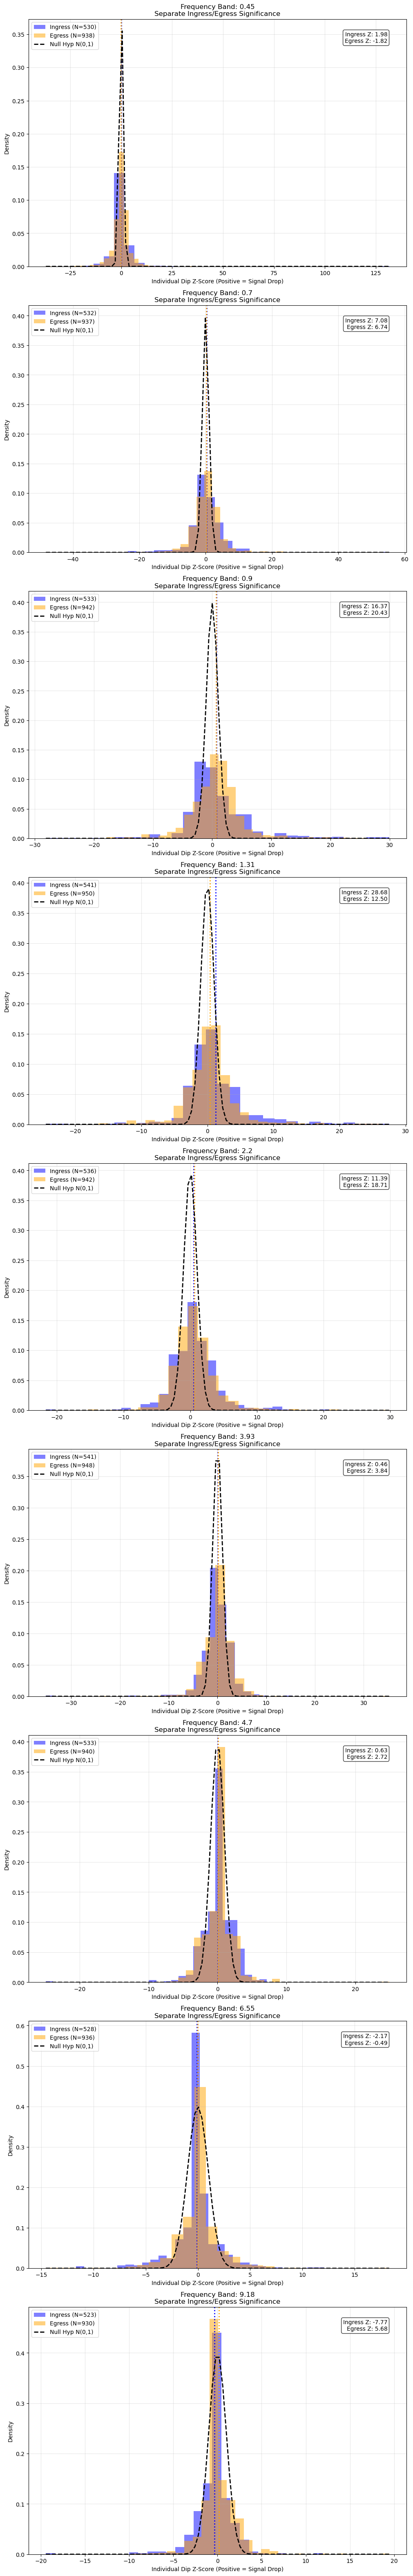

In [47]:
stats_df_lower = calculate_event_significance(data,events_df=filtered_events,data_col='rv2_coarse')
analyze_aggregated_zscores(stats_df_lower)

/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


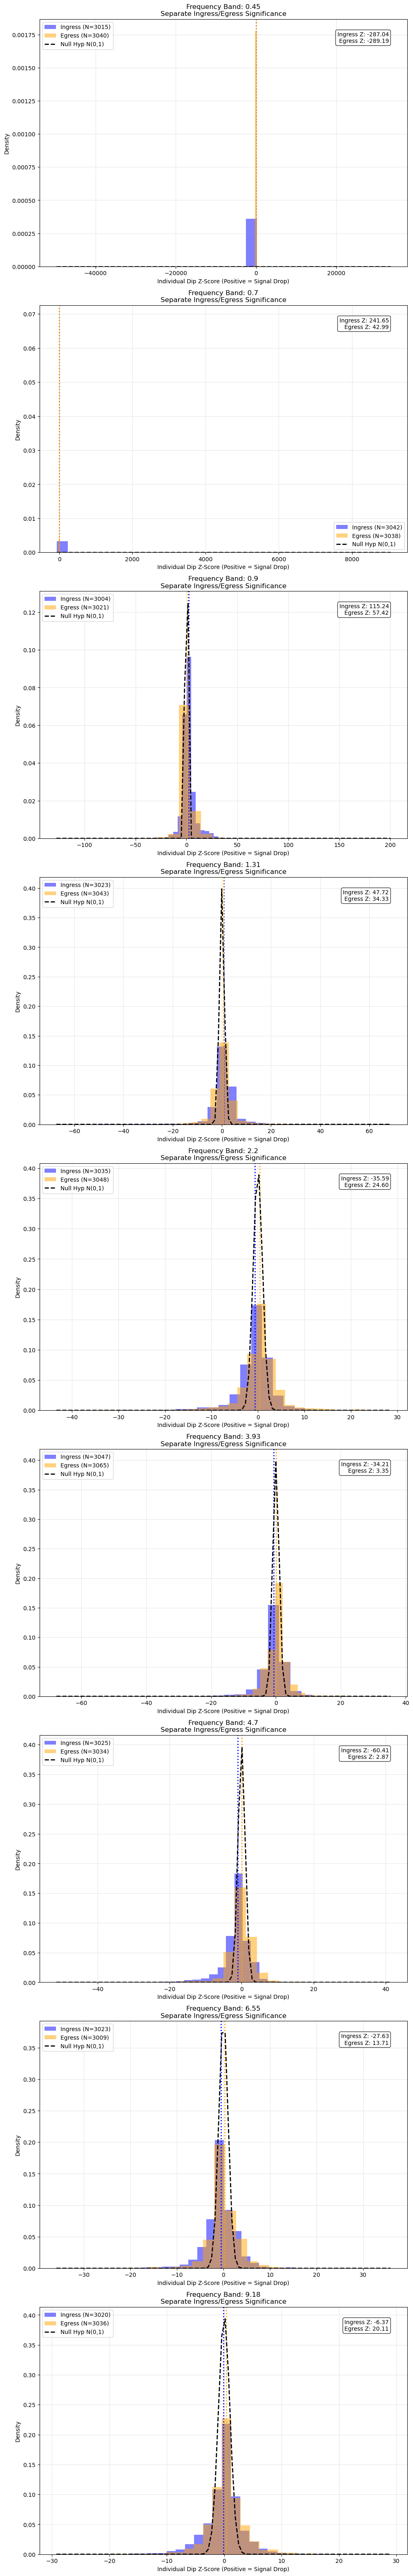

In [ ]:
stats_df_higher = calculate_event_significance(data,events_df=events,data_col='rv1_coarse')
analyze_aggregated_zscores(stats_df_higher)